In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import arviz as az
import pymc3 as pm
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
%config InlineBackend.figure_format = 'svg'

In [3]:
np.set_printoptions(formatter={float: lambda x: '{:,.3f}'.format(x)})
pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x))

# The Many Variables & The Spurious Waffles

## Codes 

### Code 5.1

In [4]:
d = pd.read_csv('../data/WaffleDivorce.csv', sep=';')

In [5]:
def create_standardizer_destandardizer(s: np.ndarray) -> np.ndarray:
    return lambda x: (x - s.mean()) / s.std(), lambda x: (x * s.std()) + s.mean()

In [6]:
std_D, dstd_D = create_standardizer_destandardizer(d['Divorce'])
std_M, dstd_M = create_standardizer_destandardizer(d['Marriage'])
std_A, dstd_A = create_standardizer_destandardizer(d['MedianAgeMarriage'])

In [7]:
d['D'] = std_D(d['Divorce'])
d['M'] = std_M(d['Marriage'])
d['A'] = std_A(d['MedianAgeMarriage'])

### Code 5.2

In [8]:
d['MedianAgeMarriage'].std()

1.2436303013880823

In [9]:
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,D,M,A
0,Alabama,AL,4.780,25.300,20.200,1.270,12.700,0.790,128,1,435080,964201,0.450,1.654,0.023,-0.606
1,Alaska,AK,0.710,25.200,26.000,2.930,12.500,2.050,0,0,0,0,0.000,1.544,1.550,-0.687
2,Arizona,AZ,6.330,25.800,20.300,0.980,10.800,0.740,18,0,0,0,0.000,0.611,0.049,-0.204
3,Arkansas,AR,2.920,24.300,26.400,1.700,13.500,1.220,41,1,111115,435450,0.260,2.094,1.655,-1.410
4,California,CA,37.250,26.800,19.100,0.390,8.000,0.240,0,0,0,379994,0.000,-0.927,-0.267,0.600


### Code 5.3

In [10]:
with pm.Model() as m51:
    a = pm.Normal('a', 0, .2)
    bA = pm.Normal('bA', 0, .5)
    sigma = pm.Exponential('sigma', 1)
    mu = a + bA * d['A']
    D = pm.Normal('D', mu, sigma, observed=d['D'])
    prior = pm.sample_prior_predictive(50, model=m51)
    trace_51 = pm.sample()

<ipython-input-10-8016d92d5389>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_51 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


### Code 5.4

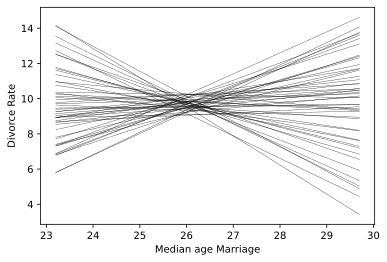

In [11]:
x = std_A(np.linspace(d['MedianAgeMarriage'].min(), d['MedianAgeMarriage'].max(), 50))

fig, ax = plt.subplots()
ax.set_xlabel('Median age Marriage')
ax.set_ylabel('Divorce Rate')

for i in range(len(prior['a'])):
    y = dstd_D(prior['a'][i] + prior['bA'][i] * x)
    ax.plot(dstd_A(x), y, color='black', linewidth=.3)

plt.show()

### Code 5.5

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


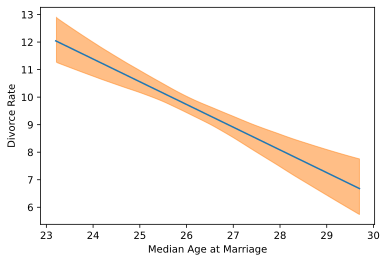

In [12]:
mu_pred = (trace_51['a'] + np.outer(x, trace_51['bA'])).T

fig, ax = plt.subplots()
ax.plot(dstd_A(x), dstd_D(mu_pred).mean(axis=0))
az.plot_hdi(dstd_A(x), dstd_D(mu_pred), hdi_prob=.89, ax=ax)
ax.set_xlabel('Median Age at Marriage')
ax.set_ylabel('Divorce Rate')
plt.show()

### Code 5.6

In [13]:
with pm.Model() as m52:
    a = pm.Normal('a', 0, .2)
    bM = pm.Normal('bM', 0, .5)
    sigma = pm.Exponential('sigma', 1)
    mu = a + bM * d['M']
    D = pm.Normal('D', mu, sigma, observed=d['D'])
    trace_52 = pm.sample()

<ipython-input-13-52fb1aabcd10>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_52 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


In [14]:
x = std_M(np.linspace(d['Marriage'].min(), d['Marriage'].max(), 50))

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


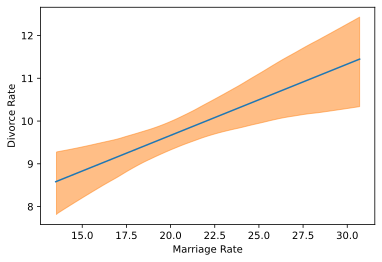

In [15]:
mu_pred = (trace_52['a'] + np.outer(x, trace_52['bM'])).T

fig, ax = plt.subplots()
ax.plot(dstd_M(x), dstd_D(mu_pred).mean(axis=0))
az.plot_hdi(dstd_M(x), dstd_D(mu_pred), hdi_prob=.89, ax=ax)
ax.set_xlabel('Marriage Rate')
ax.set_ylabel('Divorce Rate')
plt.show()

### Code 5.7

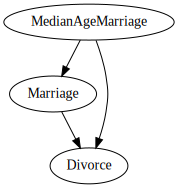

In [16]:
A = 'MedianAgeMarriage'
D = 'Divorce'
M = 'Marriage'

dag1 = CausalGraphicalModel(
    nodes=[A, M, D],
    edges=[
        (A, M),
        (A, D),
        (M, D),
    ]
)

dag1.draw()

In [17]:
d[['A', 'D', 'M']].corr()

,A,D,M
A,1.000,-0.597,-0.721
D,-0.597,1.000,0.374
M,-0.721,0.374,1.000


### Code 5.8-5.9

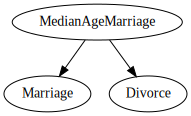

In [18]:
dag2 = CausalGraphicalModel(
    nodes=[A, M, D],
    edges=[
        (A, M),
        (A, D),
    ]
)
dag2.draw()

In [19]:
print('Dag1')
print(dag1.get_distribution())
print('Dag2')
print(dag2.get_distribution())

Dag1
P(MedianAgeMarriage)P(Marriage|MedianAgeMarriage)P(Divorce|MedianAgeMarriage,Marriage)
Dag2
P(MedianAgeMarriage)P(Divorce|MedianAgeMarriage)P(Marriage|MedianAgeMarriage)


In [20]:
print('Dag1')
print(dag1.get_all_independence_relationships())

Dag1
[]


In [21]:
print('Dag2')
print(dag2.get_all_independence_relationships())

Dag2
[('Marriage', 'Divorce', {'MedianAgeMarriage'})]


### Code 5.10

In [22]:
with pm.Model() as model_53:
    a = pm.Normal('a', 0, .2)
    bA = pm.Normal('bA', 0, .5)
    bM = pm.Normal('bM', 0, .5)
    mu = a + bA*d['A'] + bM*d['M']
    sigma = pm.Exponential('sigma', 1)
    D = pm.Normal('D', mu, sigma, observed=d['D'])
    
    prior_53 = pm.sample_prior_predictive(100)
    trace_53 = pm.sample(draws=1000, tune=10_000)

<ipython-input-22-e8ee2e8d7113>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_53 = pm.sample(draws=1000, tune=10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, bA, a]


Sampling 2 chains for 10_000 tune and 1_000 draw iterations (20_000 + 2_000 draws total) took 21 seconds.


In [23]:
az.summary(trace_53, hdi_prob=.89, kind='stats')

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.001,0.099,-0.163,0.151
bA,-0.606,0.162,-0.860,-0.358
bM,-0.056,0.160,-0.305,0.204
sigma,0.829,0.087,0.691,0.952


### Code 5.11

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


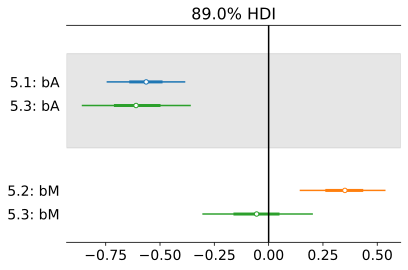

In [24]:
fig, ax = plt.subplots()
az.plot_forest(
    [trace_51, trace_52, trace_53],
    var_names=['bA', 'bM'],
    model_names=['5.1', '5.2', '5.3'],
    combined=True,
    hdi_prob=.89,
    ax=ax
)
ax.axvline(0, color='black')
plt.show()

### Code 5.12

In [25]:
N = 50
age = stats.norm().rvs(N)
mar = stats.norm(-age).rvs(N)
div = stats.norm(age).rvs(N)

### Code 5.13

In [26]:
with pm.Model() as model_54:
    a = pm.Normal('a', 0, .2)
    bAM = pm.Normal('bAM', 0, .5)
    mu = a + bAM*d['A']
    sigma = pm.Exponential('sigma', 1)
    M = pm.Normal('M', mu, sigma, observed=d['M'])
    trace_54 = pm.sample()

<ipython-input-26-77341f1a68df>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_54 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAM, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


### Code 5.14

In [27]:
mu = (trace_54['a'] + np.outer(d['A'], trace_54['bAM'])).T
mu_mean = mu.mean(axis=0)
mu_resid = d['M'] - mu_mean

### Code 5.15

In [28]:
mu = (trace_53['a'] + np.outer(d['A'], trace_53['bA']) + np.outer(d['M'], trace_53['bM'])).T
mu_mean = mu.mean(axis=0)
mu_pi = az.hdi(mu, hdi_prob=.89)

D_sim = stats.norm(mu.T, trace_53['sigma']).rvs().T
D_pi = az.hdi(D_sim, hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


In [29]:
mu.shape, D_sim.shape

((2000, 50), (2000, 50))

In [30]:
mu_pi.shape, D_pi.shape

((50, 2), (50, 2))

### Code 5.16

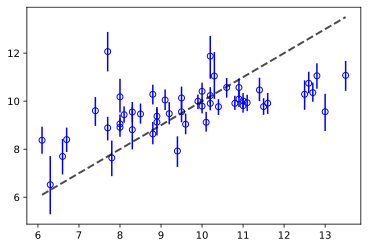

In [31]:
fig, ax = plt.subplots()
seq = np.linspace(d['Divorce'].min(), d['Divorce'].max(), 50)
ax.plot(seq, seq, color='black', linewidth=2, linestyle='--', alpha=.7)
ax.scatter(d['Divorce'], dstd_D(mu_mean), facecolors='none', edgecolors='blue')
ax.vlines(d['Divorce'], dstd_D(mu_pi[:, 0]), dstd_D(mu_pi[:, 1]), color='blue')
plt.show()

### Code 5.18

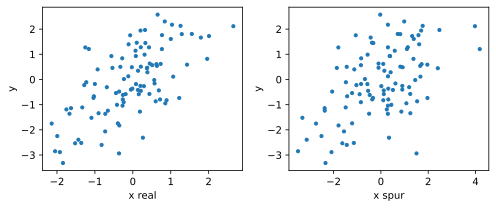

In [32]:
N = 100
x_real = stats.norm().rvs(N)
x_spur = stats.norm(x_real).rvs()
y = stats.norm(x_real).rvs()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

ax1.scatter(x_real, y, s=10)
ax1.set_ylabel('y')
ax1.set_xlabel('x real')

ax2.scatter(x_spur, y, s=10)
ax2.set_ylabel('y')
ax2.set_xlabel('x spur')

fig.tight_layout()
plt.show()

### Code 5.19

In [33]:
with pm.Model() as model_53A:
    a = pm.Normal('a', 0, .2)
    bA = pm.Normal('bA', 0, .5)
    bM = pm.Normal('bM', 0, .5)
    mu = a + bA*d['A'] + bM*d['M']
    sigma = pm.Exponential('sigma', 1)
    D = pm.Normal('D', mu, sigma, observed=d['D'])    
    
    aM = pm.Normal('aM', 0, .2)
    bAM = pm.Normal('bAM', 0, .5)
    mu_M = a + bAM*d['A']
    sigma_M = pm.Exponential('sigma_M', 1)
    M = pm.Normal('M', mu_M, sigma_M, observed=d['M'])
    
    trace_53A = pm.sample(1000, tune=10000)

<ipython-input-33-45c808277faa>:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_53A = pm.sample(1000, tune=10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_M, bAM, aM, sigma, bM, bA, a]


Sampling 2 chains for 10_000 tune and 1_000 draw iterations (20_000 + 2_000 draws total) took 27 seconds.


In [34]:
az.summary(trace_53A, kind='stats', hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.000,0.071,-0.102,0.125
bA,-0.606,0.162,-0.863,-0.351
bM,-0.067,0.160,-0.317,0.192
aM,-0.002,0.195,-0.290,0.343
bAM,-0.691,0.097,-0.855,-0.545
sigma,0.824,0.088,0.686,0.962
sigma_M,0.709,0.074,0.579,0.809


### Code 5.20

In [35]:
A_seq = np.linspace(-2, 2, 50)

### Code 5.21

In [36]:
M_mu_seq = trace_53A['aM'] + np.outer(A_seq, trace_53A['bAM'])
M_sim_seq = stats.norm(M_mu_seq, trace_53A['sigma_M']).rvs()

In [37]:
D_mu_seq = trace_53A['a'] + np.outer(A_seq, trace_53A['bA']) + np.multiply(M_sim_seq, trace_53A['bM'])
D_sim_seq = stats.norm(D_mu_seq, trace_53A['sigma']).rvs()

### Code 5.22

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


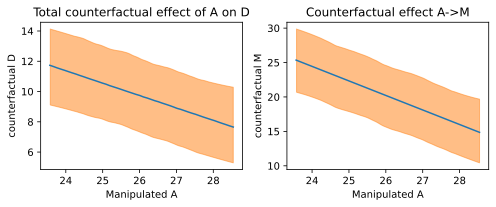

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

ax1.set_title('Total counterfactual effect of A on D')
ax1.set_xlabel('Manipulated A')
ax1.set_ylabel('counterfactual D')
ax1.plot(dstd_A(A_seq), dstd_D(D_mu_seq.mean(axis=1)))
az.plot_hdi(dstd_A(A_seq), dstd_D(D_sim_seq.T), hdi_prob=.89, ax=ax1)

ax2.set_title('Counterfactual effect A->M')
ax2.set_xlabel('Manipulated A')
ax2.set_ylabel('counterfactual M')
ax2.plot(dstd_A(A_seq), dstd_M(M_mu_seq.mean(axis=1)))
az.plot_hdi(dstd_A(A_seq), dstd_M(M_sim_seq.T), hdi_prob=.89, ax=ax2)

fig.tight_layout()
plt.show()

### Code 5.23

In [39]:
A_seq = std_A(np.array([20, 30]))

In [40]:
M_mu_seq = trace_53A['aM'] + np.outer(A_seq, trace_53A['bAM'])
M_sim_seq = stats.norm(M_mu_seq, trace_53A['sigma_M']).rvs()

In [41]:
D_mu_seq = trace_53A['a'] + np.outer(A_seq, trace_53A['bA']) + np.multiply(M_sim_seq, trace_53A['bM'])
D_sim_seq = stats.norm(D_mu_seq, trace_53A['sigma']).rvs()

In [42]:
(D_sim_seq[1, :] - D_sim_seq[0, :]).mean()

-4.491677487839637

In [43]:
(dstd_D(D_sim_seq[1, :]) - dstd_D(D_sim_seq[0, :])).mean()

-8.178508812652717

### Code 5.24

In [44]:
M_seq = np.linspace(-2, 2, 50)
D_mu_seq = trace_53A['a'] + 0*trace_53['bA'] + np.outer(M_seq, trace_53A['bM']) 
D_sim_seq = stats.norm(D_mu_seq, trace_53A['sigma']).rvs().T

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


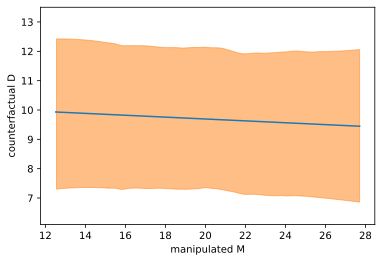

In [45]:
fig, ax = plt.subplots()

ax.plot(dstd_M(M_seq), dstd_D(D_mu_seq.mean(axis=1)))
az.plot_hdi(dstd_M(M_seq), dstd_D(D_sim_seq), hdi_prob=.89, ax=ax)
ax.set_ylim(d['Divorce'].min(), d['Divorce'].max())
ax.set_xlabel('manipulated M')
ax.set_ylabel('counterfactual D')

plt.show()

## Figures

### Figure 5.4

In [46]:
d = pd.read_csv('../data/WaffleDivorce.csv', sep=';')

std_D, dstd_D = create_standardizer_destandardizer(d['Divorce'])
std_M, dstd_M = create_standardizer_destandardizer(d['Marriage'])
std_A, dstd_A = create_standardizer_destandardizer(d['MedianAgeMarriage'])

In [47]:
with pm.Model() as model_A_to_M:
    a = pm.Normal('a', 0, .2)
    bA = pm.Normal('bA', 0, .5)
    mu = a + bA * std_A(d['MedianAgeMarriage'])
    sigma = pm.Exponential('sigma', 1)
    marriage = pm.Normal('marriage', mu, sigma, observed=std_M(d['Marriage']))
    trace_A_to_M = pm.sample(return_inferencedata=False)

AM_mean = (trace_A_to_M['a'] + np.outer(std_A(d['MedianAgeMarriage']), trace_A_to_M['bA'])).mean(axis=1)
AM_resid = std_M(d['Marriage']) - AM_mean

with pm.Model() as model_AMR_to_D:
    a = pm.Normal('a', 0, .2)
    bAMR = pm.Normal('bAMR', 0, .5)
    mu = a + bAMR * AM_resid
    sigma = pm.Exponential('sigma', 1)
    divorce = pm.Normal('divorce', mu, sigma, observed=std_D(d['Divorce']))
    trace_AMR_to_D = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAMR, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [48]:
with pm.Model() as model_M_to_A:
    a = pm.Normal('a', 0, .2)
    bM = pm.Normal('bM', 0, .5)
    mu = a + bM * std_M(d['Marriage'])
    sigma = pm.Exponential('sigma', 1)
    age = pm.Normal('age', mu, sigma, observed=std_A(d['MedianAgeMarriage']))
    trace_M_to_A = pm.sample(return_inferencedata=False)

MA_mean = (trace_M_to_A['a'] + np.outer(std_M(d['Marriage']), trace_M_to_A['bM'])).mean(axis=1)
MA_resid = std_A(d['MedianAgeMarriage']) - MA_mean

with pm.Model() as model_MAR_to_D:
    a = pm.Normal('a', 0, .2)
    bMAR = pm.Normal('bMAR', 0, .5)
    mu = a + bMAR * MA_resid
    sigma = pm.Exponential('sigma', 1)
    divorce = pm.Normal('divorce', mu, sigma, observed=std_D(d['Divorce']))
    trace_MAR_to_D = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bMAR, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


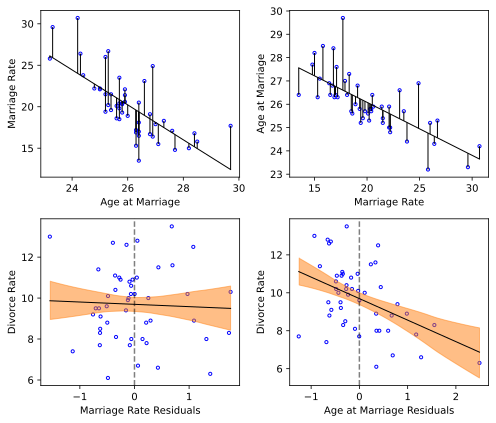

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(7, 6))

# Age to Marriage
axes[0, 0].set_xlabel('Age at Marriage')
axes[0, 0].set_ylabel('Marriage Rate')
axes[0, 0].scatter(d['MedianAgeMarriage'], d['Marriage'], facecolors='none', edgecolors='blue', s=10)

xline = std_A(np.linspace(d['MedianAgeMarriage'].min(), d['MedianAgeMarriage'].max()))
yline = (trace_A_to_M['a'] + np.outer(xline, trace_A_to_M['bA'])).mean(axis=1)
axes[0, 0].plot(dstd_A(xline), dstd_M(yline), color='black', linewidth=1)
axes[0, 0].vlines(d['MedianAgeMarriage'], d['Marriage'], dstd_M(AM_mean), color='black', linewidth=1)


# (Age to Marriage residuals) to Divorce
axes[1, 0].set_xlabel('Marriage Rate Residuals')
axes[1, 0].set_ylabel('Divorce Rate')
axes[1, 0].scatter(AM_resid, d['Divorce'], facecolors='none', edgecolors='blue', s=10)
axes[1, 0].axvline(0, color='black', linestyle='--', alpha=.5)

xline = np.linspace(AM_resid.min(), AM_resid.max(), 50)
yline = (trace_AMR_to_D['a'] + np.outer(xline, trace_AMR_to_D['bAMR'])).T
axes[1, 0].plot(xline, dstd_D(yline.mean(axis=0)), color='black', linewidth=1)
az.plot_hdi(xline, dstd_D(yline), hdi_prob=.89, ax=axes[1, 0])


# Marriage to Age
axes[0, 1].set_ylabel('Age at Marriage')
axes[0, 1].set_xlabel('Marriage Rate')
axes[0, 1].scatter(d['Marriage'], d['MedianAgeMarriage'], facecolors='none', edgecolors='blue', s=10)

xline = std_M(np.linspace(d['Marriage'].min(), d['Marriage'].max()))
yline = (trace_M_to_A['a'] + np.outer(xline, trace_M_to_A['bM'])).mean(axis=1)
axes[0, 1].plot(dstd_M(xline), dstd_A(yline), color='black', linewidth=1)
axes[0, 1].vlines(d['Marriage'], d['MedianAgeMarriage'], dstd_A(MA_mean), color='black', linewidth=1)


# (Marriage to Age residuals) to Divorce
axes[1, 1].set_xlabel('Age at Marriage Residuals')
axes[1, 1].set_ylabel('Divorce Rate')
axes[1, 1].scatter(MA_resid, d['Divorce'], facecolors='none', edgecolors='blue', s=10)
axes[1, 1].axvline(0, color='black', linestyle='--', alpha=.5)

xline = np.linspace(MA_resid.min(), MA_resid.max(), 50)
yline = (trace_MAR_to_D['a'] + np.outer(xline, trace_MAR_to_D['bMAR'])).T
axes[1, 1].plot(xline, dstd_D(yline.mean(axis=0)), color='black', linewidth=1)
az.plot_hdi(xline, dstd_D(yline), hdi_prob=.89, ax=axes[1, 1])


fig.tight_layout()
plt.show()